# Practica 3

## Parte B

### 1.
El batch_size indica numero de muestras de datos que se procesan en cada iteracion antes de actualizar los pesos de la red neuronal. Un batch_size pequeño en este hace actualizaciones mas frecuentes pero mas ruidosas porque cada actualizacion se basa en pocos ejemplos. Un batch_size grande produce actualizaciones mas estables pero menos frecuentes.
Por ejemplo, si hay 10000 imagenes de entrenamiento y un batch_size de 4, cada epoch tendrá 10000 / 4 = 2500 iteraciones.

### 2.
Es necesario para mezclar de modo rando, los datos de entrenamiento en cada epoch para reducir el sesgo en el aprendizaje. Evita overfitting - cuando red aprende patrones especificos de los datos.

### 3.
a) constructor
```python
def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
```
- **super(Net, self).__init__()** inicializa clase parent nn.Module;
- **self.conv1 = nn.Conv2d(3, 6, 5)** primera capa convolucional con 3 canales de  entrada RGB, 6 canales de salida y kernel de tamaño 5 por 5;
- **self.pool = nn.MaxPool2d(2, 2)** capa de pooling con un kernel de 2 por 2 y un stride de 2, que divide por la mitad la dimension espacial;
- **self.conv2 = nn.Conv2d(6, 16, 5)** segunda capa convolucional con 6 canales de entrada, 16 canales de salida y un kernel de 5 por 5;
- **self.fc1 = nn.Linear(16 * 5 * 5, 120)** primera capa completamente conectada. El numero 1655 es las dimensiones despues de aplicar las convoluciones y pooling a la imagen original;
- **self.fc2 = nn.Linear(120, 84)** segunda capa completamente conectada;
- **self.fc3 = nn.Linear(84, 10)** capa de salida con 10 neuronas, una para cada clase del 0 al 9.

b) forward

```python
def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
```

- **x = self.pool(F.relu(self.conv1(x)))** aplica la primera convolucion, con la funcion ReLU y max pooling;
- **x = self.pool(F.relu(self.conv2(x)))** aplica la segunda convolucion, ReLU y max pooling;
- **x = x.view(-1, 16 * 5 * 5)** cambia shape del tensor para adaptarlo a la capa completamente conectada. El -1 significa que PyTorch calculara la primera dimension basando en el tamaño del batch;
- **x = F.relu(self.fc1(x))** aplica la primera capa FC con ReLU;
- **x = F.relu(self.fc2(x))** aplica la segunda capa FC con ReLU;
- **x = self.fc3(x)** aplica la capa de salida sin funcion de activacion.

### 4.

```python
loss.backward() # Cálculo de gradientes
optimizer.step() # Actualización de pesos
```

Antes de estas operaciones, hay que hacer forward passc, alcular la perdida y set los gradientes a 0s. Porque Torch acumula gradientes, por eso necesitamos ponerlos a 0s antes de cada paso de actualizacion.

### 5.

ejemplo de 'outputs' (que obteni durante el tutorial):
```
tensor([[-2.3196, -3.3134,  1.4663,  2.5404,  1.8785,  2.4044,  2.0425,  0.7455,
         -3.7127, -2.5388],
        [-1.9709, -2.6633,  0.9064,  2.4308,  0.5249,  3.1620, -0.4499,  1.3738,
         -2.2363, -1.7061],
        [ 0.7213,  3.4145,  0.2469, -0.7085, -0.6535, -0.8410, -1.0262, -1.2886,
         -1.0279,  1.4229],
        [-1.2843, -2.1417,  1.3676, -0.4372,  3.8031,  0.8632, -1.6142,  5.8503,
         -5.0227, -1.5920]], grad_fn=<AddmmBackward0>)
```

Es un tensor de dimensiones `[batch_size, num_classes]` donde batch_size es numero de imagenes procesadas en el batch y num_classes es numero de clases que tenemos, en caso de tutorial son 10. Cada fila del tensor corresponde a una imagen, y contiene 10 valores que representan los logits para cada una de las clases. Para obtener probabilidades, hay que pasarlos por una funcion softmax.

### Practica

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

Cargamos y preparamos el dataset MNIST

In [2]:
SEED = 123

torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
def load_mnist_dataset(bs):
  # en este caso solo hay un canal, en vez de 3
  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))])

  # y cambiamos batch_size a 8 en vez de 4
  batch_size = bs

  trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

  testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

  classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
  return trainloader, testloader, classes

Las configuarciones, que vamos a tener:


**Configuracion 1**
- batch_size: 16
- capas convolucionales: 2
- capas conectadas: 3
- tamaño de kernel: 5 por 5
- numero de filtros: [16, 32]
- tamaño de pooling: 2 por 2
- neuronas en capas ocultas: [120, 84]
- tasa de aprendizaje: 0.01
- epochs: 3

**Configuracion 2**
- batch_size: 64
- capas convolucionales: 3
- capas conectadas: 4
- tamaño de kernel: 3 por 3
- numero de filtros: [32, 64, 128]
- tamaño de pooling: 3 por 3 con stride=2 y 2 por 2
- neuronas en capas ocultas: [256, 128, 64]
- tasa de aprendizaje: 0.001
- epochs: 5


In [4]:
# preparamos dos configuraciones con distinto batch_size

trainloader1, testloader1, classes1 = load_mnist_dataset(16)
trainloader2, testloader2, classes2 = load_mnist_dataset(64)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.80MB/s]


In [5]:
import matplotlib.pyplot as plt

def visualize_train_data(trainloader, classes, batch_size):
  def imshow(img):
      img = img / 2 + 0.5
      npimg = img.numpy()
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
      plt.show()

  # para ver algunas imagenes de entrenamiento con sus labels
  dataiter = iter(trainloader)
  images, labels = next(dataiter)

  # mostrar imagenes
  imshow(torchvision.utils.make_grid(images))
  # formatamos los labels para que cada linea tiene 8 numeros
  for i in range(0, batch_size, 8):
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(i, i+8)))

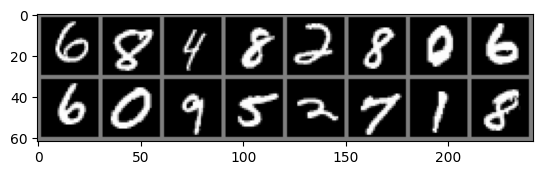

6     8     4     8     2     8     0     6    
6     0     9     5     2     7     1     8    


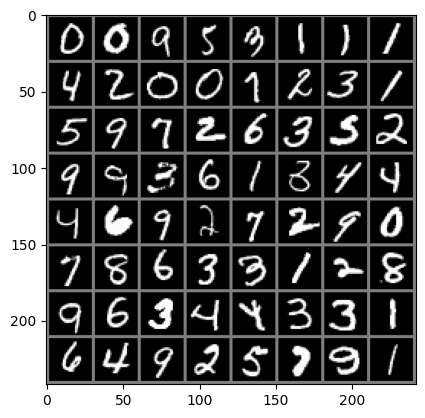

0     0     9     5     3     1     1     1    
4     2     0     0     7     2     3     1    
5     9     7     2     6     3     5     2    
9     9     3     6     1     3     4     4    
4     6     9     2     7     2     9     0    
7     8     6     3     3     1     2     8    
9     6     3     4     4     3     3     1    
6     4     9     2     5     7     9     1    


In [6]:
# visualizamos datos para cada de config
visualize_train_data(trainloader1, classes1, 16)
visualize_train_data(trainloader2, classes2, 64)

Definimos Redes para cada config

In [7]:
class Net1(nn.Module):
  def __init__(self):
    super(Net1, self).__init__()
    # primera capa convolucional con entrada 1 canal, salida 16 feature maps, kernel 5 por 5
    self.conv1 = nn.Conv2d(1, 16, 5)
    # capa de max pooling 2 por 2
    self.pool1 = nn.MaxPool2d(2, 2)
    # segunda capa convolucional con entrada 16 feature maps, salida 32 feature maps, kernel 5 por 5
    self.conv2 = nn.Conv2d(16, 32, 5)
    # capa de max pooling 2 por 2
    self.pool2 = nn.MaxPool2d(2, 2)
    # capas completamente conectadas
    self.fc1 = nn.Linear(32 * 4 * 4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # aplicamos la primera capa convolucional seguida de ReLU y pooling
    x = self.pool1(F.relu(self.conv1(x)))
    # aplicamos la segunda capa convolucional seguida de ReLU y pooling
    x = self.pool2(F.relu(self.conv2(x)))
    # aplanamos el tensor para las capas lineales
    x = x.view(-1, 32 * 4 * 4)
    # aplicamos las capas lineales con funciones de activacion ReLU
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    # la ultima capa sin funcion de activacion
    x = self.fc3(x)
    return x

In [11]:
class Net2(nn.Module):
  def __init__(self):
    super(Net2, self).__init__()
    # primera capa convolucional con entrada 1 canal, salida 32 feature maps, kernel 3 por 3, padding 1
    self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
    # capa de max pooling 3 por 3 con stride 2
    self.pool1 = nn.MaxPool2d(3, stride=2, padding=1)
    # segunda capa convolucional con entrada 32 feature maps, salida 64 feature maps, kernel 3 por 3, padding 1
    self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
    # capa de max pooling 2 por 2
    self.pool2 = nn.MaxPool2d(2, 2)
    # tercera capa convolucional con entrada 64 feature maps, salida 128 feature maps, kernel 3 por 3, padding 1
    self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
    # capa de max pooling 2 por 2
    self.pool3 = nn.MaxPool2d(2, 2)
    # capas completamente conectadas
    self.fc1 = nn.Linear(128 * 3 * 3, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)
    # # capa de dropout para reducir el overfitting
    # self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    # aplicamos primera capa convolucional + ReLU + pooling
    x = self.pool1(F.relu(self.conv1(x)))
    # aplicamos segunda capa convolucional + ReLU + pooling
    x = self.pool2(F.relu(self.conv2(x)))
    # aplicamos tercera capa convolucional + ReLU + pooling
    x = self.pool3(F.relu(self.conv3(x)))
    # aplanamos el tensor
    x = x.view(-1, 128 * 3 * 3)
    # aplicamos capas lineales con funciones de activación y dropout
    x = F.relu(self.fc1(x))
    # x = self.dropout(x)
    x = F.relu(self.fc2(x))
    # x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

Entrenamos dos Redes configuradas

In [12]:
def train_network(net, trainloader, criterion, optimizer, epochs, device):
  net.to(device)
  losses = []

  for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)

      # set los gradientes a 0
      optimizer.zero_grad()
      # forward pass
      outputs = net(inputs)
      # perdida
      loss = criterion(outputs, labels)
      # gradientes
      loss.backward()
      # actualizaciones de pesos
      optimizer.step()

      # resultados
      running_loss += loss.item()
      if i % 200 == 199:
        avg_loss = running_loss / 200
        losses.append(avg_loss)
        print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {avg_loss:.3f}')
        running_loss = 0.0

  print('Finished Training')
  return net, losses

In [15]:
# entrenamiento para cada configuracion
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Utilizando {device}')

net1 = Net1()
net2 = Net2()

net1, losses1 = train_network(net1, trainloader1, nn.CrossEntropyLoss(), optim.SGD(net1.parameters(), lr=0.01, momentum=0.9), 3, device)
net2, losses2 = train_network(net2, trainloader2, nn.CrossEntropyLoss(), optim.SGD(net2.parameters(), lr=0.001, momentum=0.9), 5, device)

Utilizando cuda
[Epoch 1, Batch 200] loss: 1.393
[Epoch 1, Batch 400] loss: 0.331
[Epoch 1, Batch 600] loss: 0.208
[Epoch 1, Batch 800] loss: 0.165
[Epoch 1, Batch 1000] loss: 0.142
[Epoch 1, Batch 1200] loss: 0.142
[Epoch 1, Batch 1400] loss: 0.095
[Epoch 1, Batch 1600] loss: 0.099
[Epoch 1, Batch 1800] loss: 0.106
[Epoch 1, Batch 2000] loss: 0.082
[Epoch 1, Batch 2200] loss: 0.077
[Epoch 1, Batch 2400] loss: 0.089
[Epoch 1, Batch 2600] loss: 0.078
[Epoch 1, Batch 2800] loss: 0.079
[Epoch 1, Batch 3000] loss: 0.061
[Epoch 1, Batch 3200] loss: 0.084
[Epoch 1, Batch 3400] loss: 0.056
[Epoch 1, Batch 3600] loss: 0.048
[Epoch 2, Batch 200] loss: 0.051
[Epoch 2, Batch 400] loss: 0.044
[Epoch 2, Batch 600] loss: 0.045
[Epoch 2, Batch 800] loss: 0.056
[Epoch 2, Batch 1000] loss: 0.056
[Epoch 2, Batch 1200] loss: 0.058
[Epoch 2, Batch 1400] loss: 0.054
[Epoch 2, Batch 1600] loss: 0.052
[Epoch 2, Batch 1800] loss: 0.054
[Epoch 2, Batch 2000] loss: 0.046
[Epoch 2, Batch 2200] loss: 0.044
[Epoch

In [16]:
torch.save(net1.state_dict(), 'mnist_net1.pth')
torch.save(net2.state_dict(), 'mnist_net2.pth')

Evaluacion de ambas configuraciones

In [20]:
def evaluate_network(net, testloader, device):
  net.to(device)

  correct = 0
  total = 0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))

  with torch.no_grad():
    for data in testloader:
      images, labels = data[0].to(device), data[1].to(device)
      # forward pass
      outputs = net(images)
      # predicciones
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # calcular precision por clase
      c = (predicted == labels).squeeze()
      for i in range(labels.size(0)):
        label = labels[i]
        class_correct[label] += c[i].item()
        class_total[label] += 1

  # calcular precision total
  accuracy = 100 * correct / total
  print(f'precision conjunto de prueba: {accuracy:.2f}%')

  # calcular accuracy por clase
  class_accuracy = []
  for i in range(10):
    if class_total[i] > 0:
      class_acc = 100 * class_correct[i] / class_total[i]
      print(f'precision clase {i}: {class_acc:.2f}%')
      class_accuracy.append(class_acc)
    else:
      class_accuracy.append(0)

  return accuracy, class_accuracy

In [18]:
# cargamos modelos de memoria
net1 = Net1()
net2 = Net2()
net1.load_state_dict(torch.load('mnist_net1.pth', weights_only=True))
net2.load_state_dict(torch.load('mnist_net2.pth', weights_only=True))

<All keys matched successfully>

In [21]:
# evaluamos cada configuracion
print('Config 1')
accuracy1, class_accuracy1 = evaluate_network(net1, testloader1, device)
print('\nConfig 2')
accuracy2, class_accuracy2 = evaluate_network(net2, testloader2, device)

Config 1
precision conjunto de prueba: 98.73%
precision clase 0: 99.29%
precision clase 1: 99.21%
precision clase 2: 98.64%
precision clase 3: 99.60%
precision clase 4: 98.98%
precision clase 5: 96.08%
precision clase 6: 98.64%
precision clase 7: 98.74%
precision clase 8: 99.69%
precision clase 9: 98.12%

Config 2
precision conjunto de prueba: 97.11%
precision clase 0: 99.08%
precision clase 1: 98.59%
precision clase 2: 95.64%
precision clase 3: 96.63%
precision clase 4: 97.56%
precision clase 5: 98.43%
precision clase 6: 97.60%
precision clase 7: 93.77%
precision clase 8: 96.82%
precision clase 9: 97.13%


Dibujamos diagramas de resultados

In [22]:
# graficar perdida durante el entrenamiento
def plot_loss(losses, title):
  plt.figure(figsize=(10, 5))
  plt.plot(losses)
  plt.title(title)
  plt.xlabel('iters x200')
  plt.ylabel('perdida')
  plt.grid(True)
  plt.show()

# graficar la precision por clase
def plot_class_accuracy(class_accuracy1, class_accuracy2):
  classes = list(range(10))
  x = np.arange(len(classes))
  width = 0.35

  fig, ax = plt.subplots(figsize=(12, 5))
  rects1 = ax.bar(x - width/2, class_accuracy1, width, label='config 1')
  rects2 = ax.bar(x + width/2, class_accuracy2, width, label='config 2')

  ax.set_ylabel('precision %')
  ax.set_title('precision por clase')
  ax.set_xticks(x)
  ax.set_xticklabels(classes)
  ax.legend()

  plt.grid(True, axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()
  plt.show()

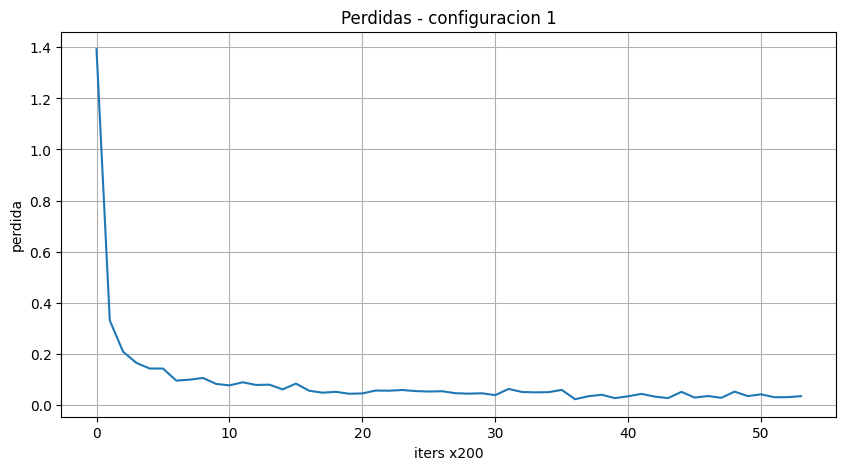

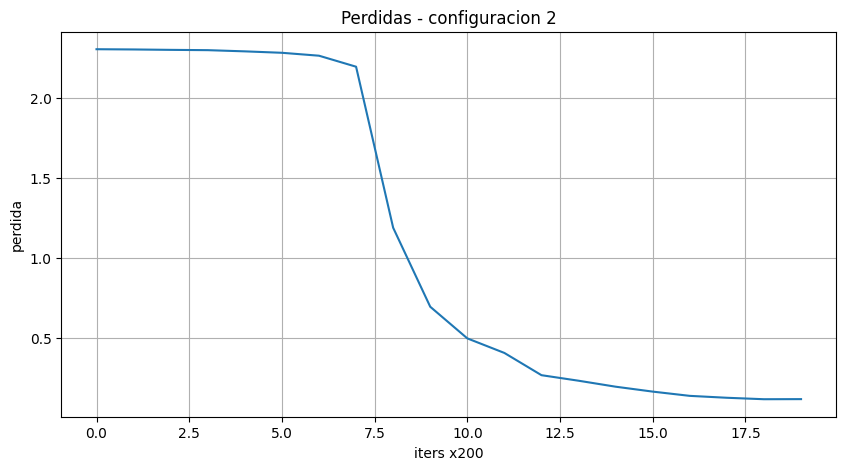

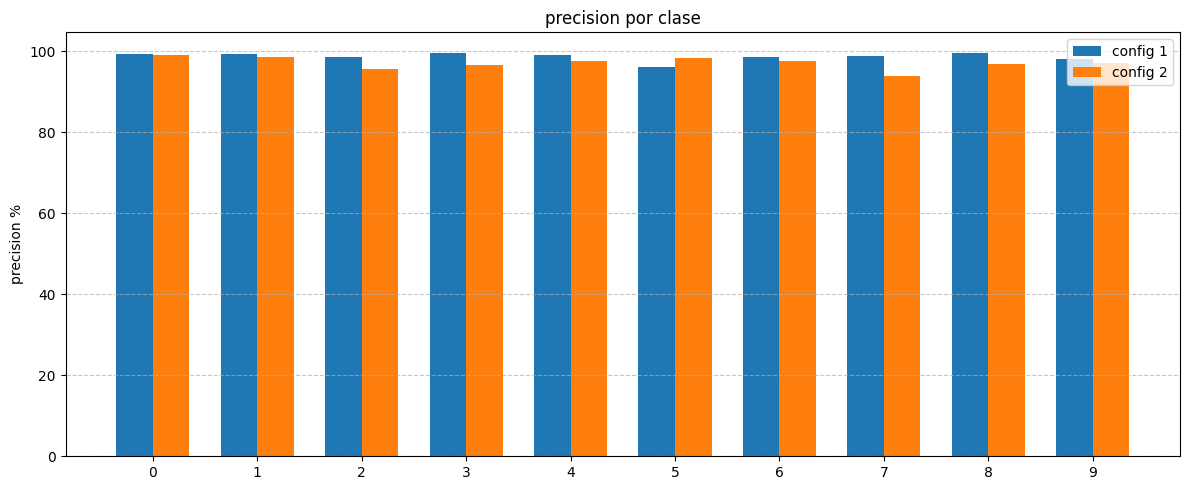

Precisiones total
config 1: 98.73%
config 2: 97.11%


In [23]:
# configuracion 1
plot_loss(losses1, 'Perdidas - configuracion 1')

# configuracion 2
plot_loss(losses2, 'Perdidas - configuracion 2')

# precision por clase
plot_class_accuracy(class_accuracy1, class_accuracy2)

print("Precisiones total")
print(f"config 1: {accuracy1:.2f}%")
print(f"config 2: {accuracy2:.2f}%")

### Conclusiones

Podemos ver que la configuracion 1, aunque mas sencilla, es mejor en precision que la configuracion 2. Esta diferencia es tanto en la precision global como en la por clase, con los mayores diferencias en los digitos 2, 3, 7 y 8. La evolucion de la perdida durante el entrenamiento muestra que la configuracion 1 converge mas rapido y estabiliza la perdida en valores mas bajos, mientras que la configuracion 2 presenta una reduccion de perdida mas lenta.

Los razones por eso pueden ser los suguientes. La configuracion 2, con mas capas convolucionales y filtros, no es la solucion mejor en un dataset sencillo como MNIST, donde la arquitectura mas compacta puede ser mas efectiva. El uso de kernels de 5 por 5 en la configuracion 1 parece ser mas adecuada que 3 por 3 en la configuracion 2. Tambine es importante la diferencia entre tasas de aprendizaje, y un batch size mas pequeño para convergencia mas rapida.